# Análise De Queimadas EUA + Aplicação e instrução para prevenção de tragédias

- Vinicius Silva - RM553240
- Victor Didoff - RM552965
- Matheu Zottis - RM94119

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime
import seaborn as sns

In [5]:
# Carregar os dados
file_path = "wildfires.csv"
df = pd.read_csv(file_path, low_memory=False)

np.random.seed(14)

# Seleciona 500 mil quemadas aleatórias com base na semente 14 (0+5+9)
amostra = df.sample(n=500_000, replace=False, random_state=14)

### Vamos analisar as Causas de incendios\queimadas no geral.

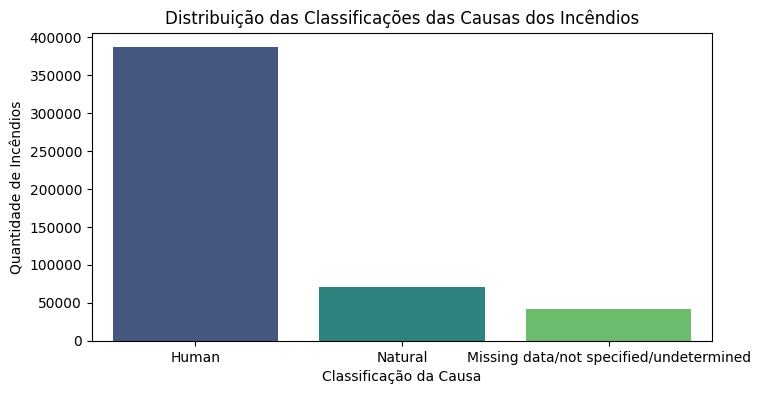

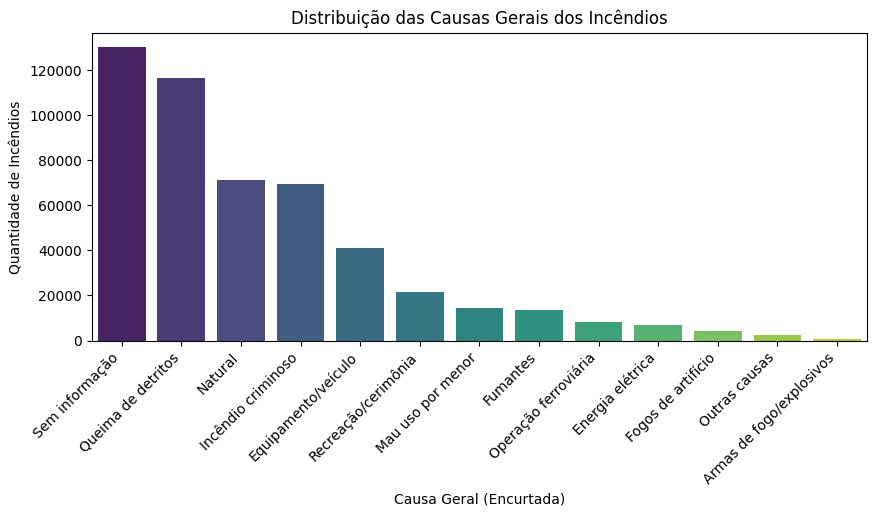

In [8]:
# Gráfico de classificação das causas dos incêndios
classificacao_causas = amostra['NWCG_CAUSE_CLASSIFICATION'].value_counts()
fig_classificacao, ax_classificacao = plt.subplots(figsize=(8, 4))
sns.barplot(x=classificacao_causas.index, y=classificacao_causas.values, ax=ax_classificacao, hue=classificacao_causas.index, palette='viridis', dodge=False, legend=False)
ax_classificacao.set_xlabel("Classificação da Causa")
ax_classificacao.set_ylabel("Quantidade de Incêndios")
ax_classificacao.set_title("Distribuição das Classificações das Causas dos Incêndios")
plt.show()

#Lista para encurtar os nomes das causas gerais em português
causas_short_pt = [
    "Sem informação", "Queima de detritos", "Natural", "Incêndio criminoso",
    "Equipamento/veículo", "Recreação/cerimônia", "Mau uso por menor",
    "Fumantes", "Operação ferroviária", "Energia elétrica",
    "Fogos de artifício", "Outras causas", "Armas de fogo/explosivos"
]

# Contar as causas gerais
causas = amostra['NWCG_GENERAL_CAUSE'].value_counts()

fig_causa, ax_causa = plt.subplots(figsize=(10, 4))
sns.barplot(x=causas_short_pt, y=causas.values, ax=ax_causa, hue=causas_short_pt, palette="viridis")
ax_causa.set_xlabel("Causa Geral (Encurtada)")
ax_causa.set_ylabel("Quantidade de Incêndios")
ax_causa.set_title("Distribuição das Causas Gerais dos Incêndios")
plt.xticks(rotation=45, ha='right')
plt.show()



A maioria dos casos de Incendios e queimadas é humano, o que é deveras preocupante. Mesmo as causas humanas sendo bem diversas elas superam as naturais. 

### Causas com intervalos de Confiança

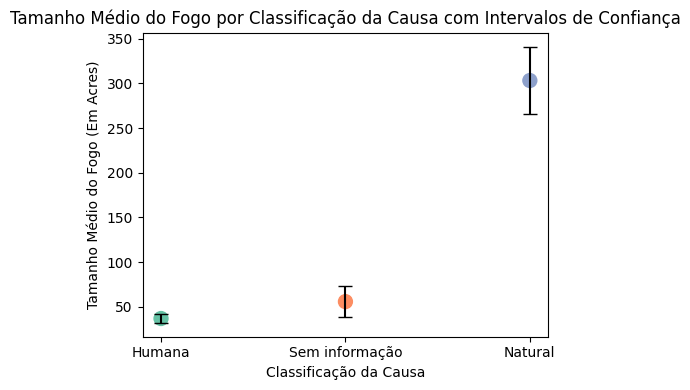

In [9]:
# Dicionário de tradução para português
causas_pt = {
    "Human": "Humana",
    "Natural": "Natural",
    "Missing data/not specified/undetermined": "Sem informação"
}

# Calcular o tamanho médio do fogo por classificação da causa
mean_fire_size = amostra.groupby('NWCG_CAUSE_CLASSIFICATION')['FIRE_SIZE'].mean()

# Calcular o desvio padrão e o tamanho da amostra para cada grupo
std_fire_size = amostra.groupby('NWCG_CAUSE_CLASSIFICATION')['FIRE_SIZE'].std()
count_fire_size = amostra.groupby('NWCG_CAUSE_CLASSIFICATION')['FIRE_SIZE'].count()

# Calcular o intervalo de confiança de 95%
import scipy.stats as stats
conf = 0.95
alpha = 1 - conf
z = stats.t.ppf(1 - alpha/2, count_fire_size - 1)
ci_lower = mean_fire_size - z * (std_fire_size / count_fire_size**0.5)
ci_upper = mean_fire_size + z * (std_fire_size / count_fire_size**0.5)

# Renomear o índice para português
mean_fire_size_pt = mean_fire_size.rename(index=causas_pt)
ci_lower_pt = ci_lower.rename(index=causas_pt)
ci_upper_pt = ci_upper.rename(index=causas_pt)

# Plotar o gráfico com nomes em português
fig_ci, ax_ci = plt.subplots(figsize=(5, 4))
colors = sns.color_palette('Set2', len(mean_fire_size_pt))

ax_ci.scatter(mean_fire_size_pt.index, mean_fire_size_pt.values, color=colors, s=100, label="Tamanho Médio do Fogo")
ax_ci.errorbar(mean_fire_size_pt.index, mean_fire_size_pt.values, 
               yerr=[mean_fire_size_pt.values - ci_lower_pt, ci_upper_pt - mean_fire_size_pt.values], 
               fmt='none', c='black', capsize=5)

ax_ci.set_xlabel("Classificação da Causa")
ax_ci.set_ylabel("Tamanho Médio do Fogo (Em Acres)")
ax_ci.set_title("Tamanho Médio do Fogo por Classificação da Causa com Intervalos de Confiança")
plt.tight_layout()
plt.show()


No entanto é visto que as queimadas por causas naturais acaba se alastrando muito mais que as geradas por humanos.

# Mapa dos EUA e Categorias de Queimadas

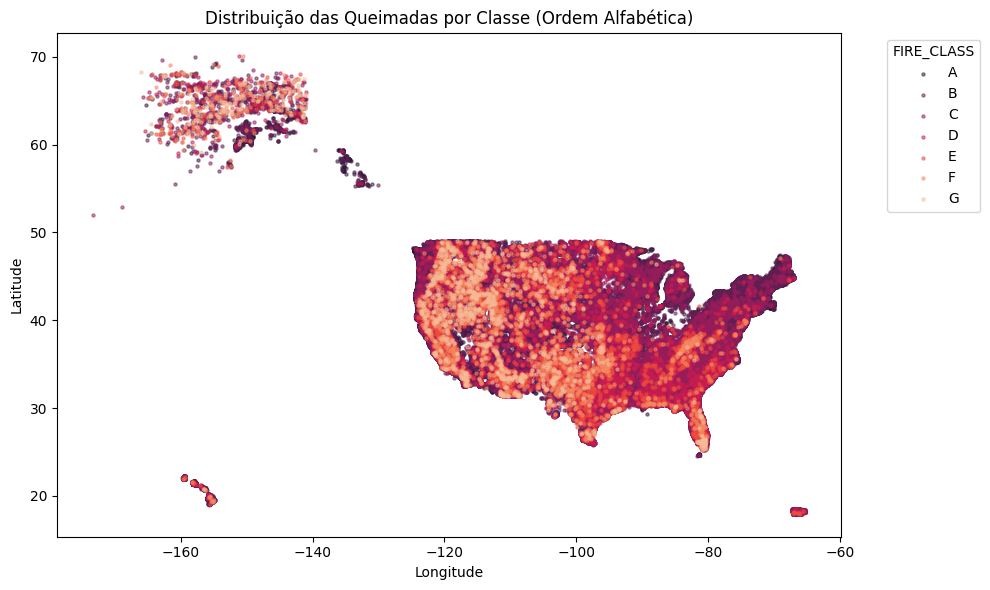

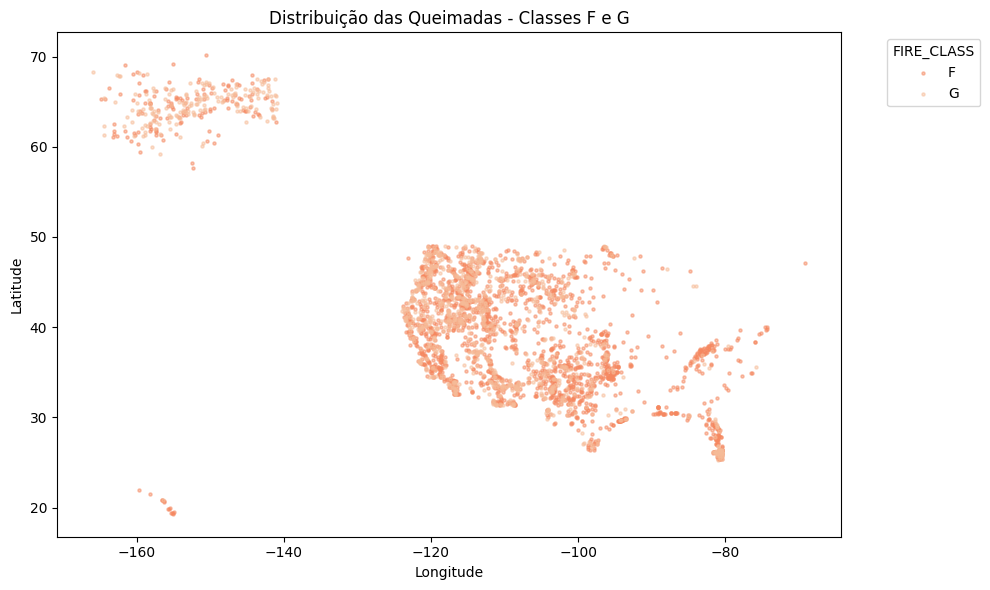

In [10]:
# Organizar as classes em ordem alfabética
fire_classes_sorted = sorted(amostra['FIRE_SIZE_CLASS'].unique())
palette_sorted = sns.color_palette("rocket", len(fire_classes_sorted))
color_map_sorted = dict(zip(fire_classes_sorted, palette_sorted))

# Gráfico de todas as classes em ordem alfabética
fig, ax = plt.subplots(figsize=(10, 6))
for fire_class in fire_classes_sorted:
    subset = amostra[amostra['FIRE_SIZE_CLASS'] == fire_class]
    ax.scatter(subset['LONGITUDE'], subset['LATITUDE'],
               label=fire_class,
               color=color_map_sorted[fire_class],
               alpha=0.5, s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribuição das Queimadas por Classe (Ordem Alfabética)')
ax.legend(title='FIRE_CLASS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico apenas para classes F e G
fig, ax = plt.subplots(figsize=(10, 6))
for fire_class in ['F', 'G']:
    subset = amostra[amostra['FIRE_SIZE_CLASS'] == fire_class]
    ax.scatter(subset['LONGITUDE'], subset['LATITUDE'],
               label=fire_class,
               color=color_map_sorted[fire_class],
               alpha=0.5, s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribuição das Queimadas - Classes F e G')
ax.legend(title='FIRE_CLASS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

è visto que as regioes atigidas com queimadas de maior impacto foram as regioes oeste e extremo sul
'

# Regressão Linear de insendios naturais por Ano e analises anuais e mensais


Total de incêndios naturais: 71180


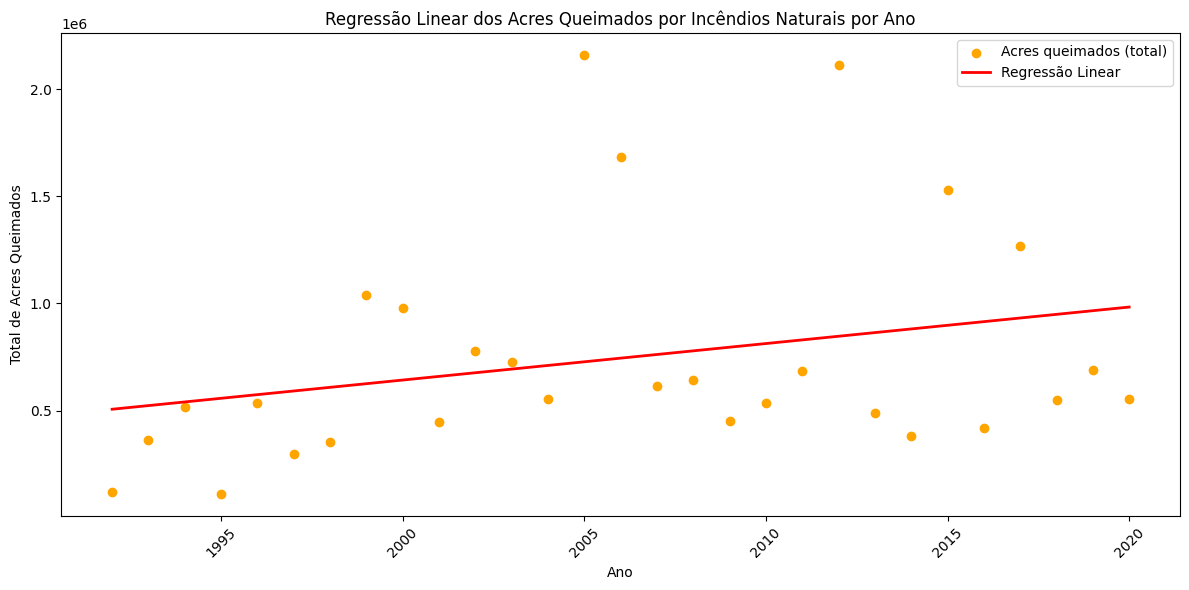

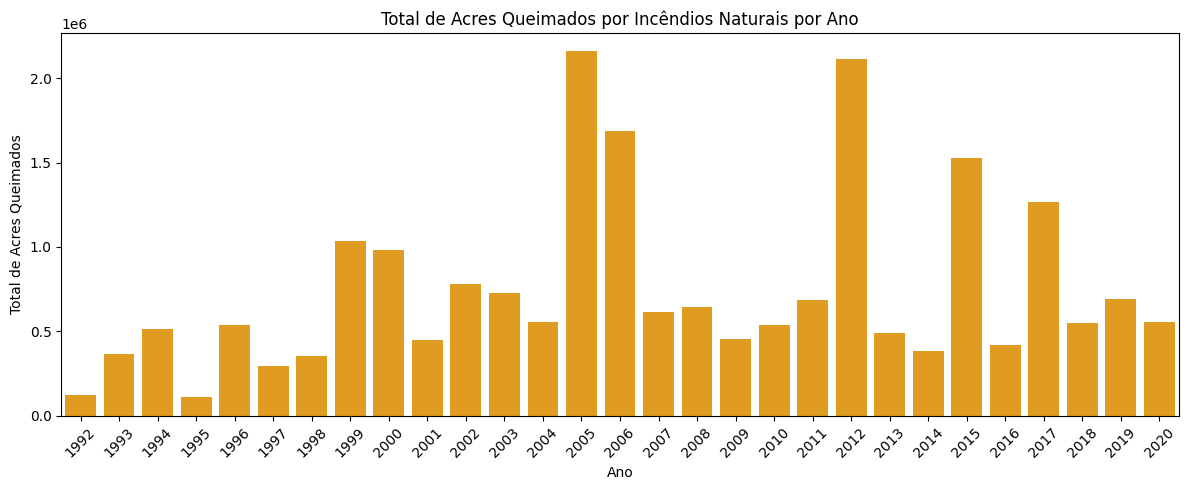

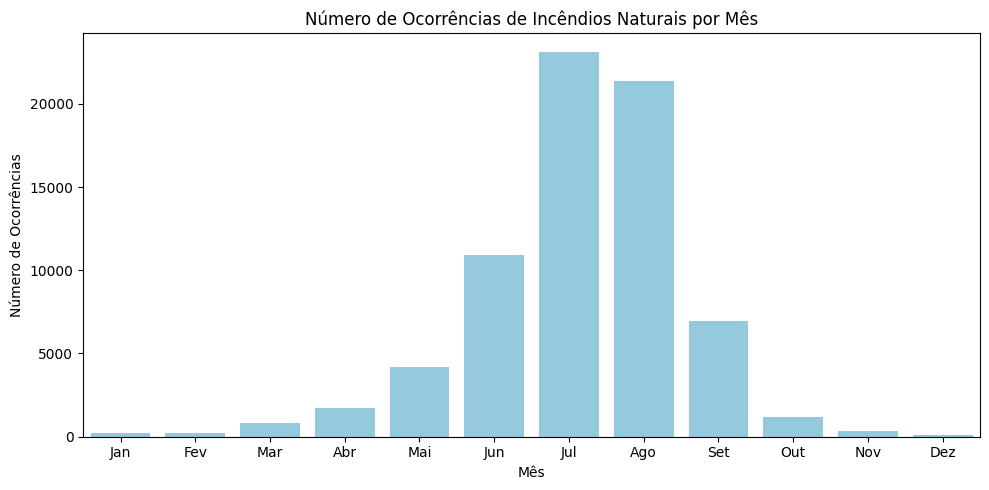

In [11]:

from scipy.stats import linregress

# Filtrar apenas incêndios naturais
naturais = amostra[amostra['NWCG_CAUSE_CLASSIFICATION'] == 'Natural']
count_naturais = naturais['FIRE_SIZE'].count()
print(f"Total de incêndios naturais: {count_naturais}")

# Calcular total de acres queimados por incêndios naturais a cada ano
acres_por_ano_naturais = naturais.groupby('FIRE_YEAR')['FIRE_SIZE'].sum().reset_index()

# Regressão linear: acres queimados por ano (causas naturais)
x = acres_por_ano_naturais['FIRE_YEAR']
y = acres_por_ano_naturais['FIRE_SIZE']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
y_pred = slope * x + intercept

# Plotar a regressão linear sobre os dados reais (scatter)
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x, y, color='orange', label='Acres queimados (total)')
ax.plot(x, y_pred, color='red', linewidth=2, label='Regressão Linear')
ax.set_xlabel('Ano')
ax.set_ylabel('Total de Acres Queimados')
ax.set_title('Regressão Linear dos Acres Queimados por Incêndios Naturais por Ano')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Gráfico de barras: total de acres queimados por incêndios naturais a cada ano
plt.figure(figsize=(12, 5))
sns.barplot(data=acres_por_ano_naturais, x='FIRE_YEAR', y='FIRE_SIZE', color='orange')
plt.xlabel('Ano')
plt.ylabel('Total de Acres Queimados')
plt.title('Total de Acres Queimados por Incêndios Naturais por Ano')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras: número de ocorrências de incêndios naturais por mês
naturais = naturais.copy()
naturais['MES'] = pd.to_datetime(naturais['DISCOVERY_DATE']).dt.month
ocorrencias_por_mes = naturais.groupby('MES').size().reset_index(name='OCORRENCIAS')

plt.figure(figsize=(10, 5))
sns.barplot(data=ocorrencias_por_mes, x='MES', y='OCORRENCIAS', color='skyblue')
plt.xlabel('Mês')
plt.ylabel('Número de Ocorrências')
plt.title('Número de Ocorrências de Incêndios Naturais por Mês')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.tight_layout()
plt.show()

Nos gráficos acima é visto que as queimadas de fato atingem uma grande area. Por ano vemos um crescimento sutil no impacto das queimadas.Temos também algums exemplos exepcionais como os anos de 2005,2006,2012,2015,2017 que foram muito afetados.  

Uma variável que deve se levar em conta é o verão extremamente seco principalmente nas regioes centrais e mais ao oeste dos estados unidos que são no mes de Junho\Julho onde é visto um aumento expressivo na expansão dos insendios.

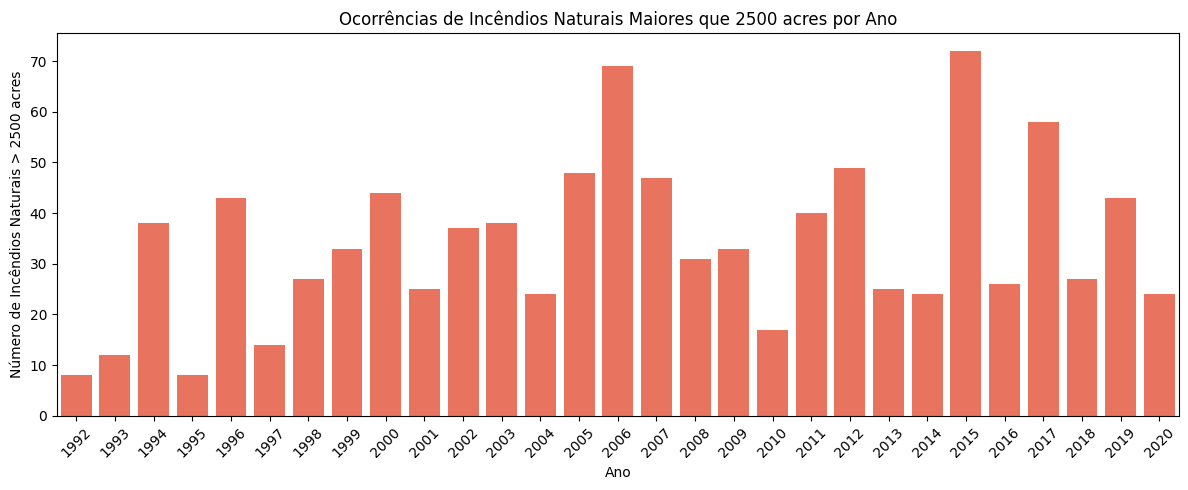

Média de ocorrências de incêndios naturais > 2500 acres por ano: 33.93


c:\AppData\Local\Temp\ipykernel_20432\3617130248.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contagem_grande = amostra_grande.groupby(['FIRE_YEAR', 'INTERVALO_DIAS']).size().unstack(fill_value=0)


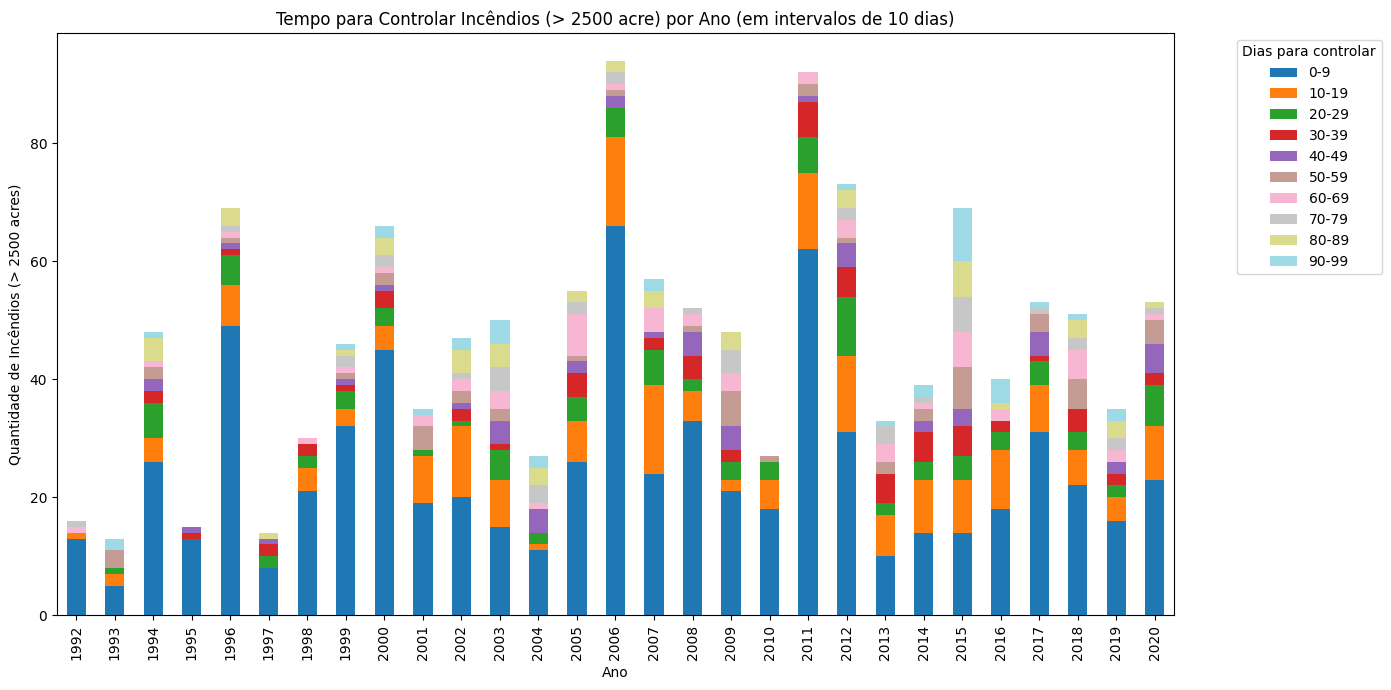

In [12]:
# Filtrar incêndios naturais maiores que 2500 acres
naturais_grandes = naturais[naturais['FIRE_SIZE'] > 2500]

# Contar por ano
ocorrencias_naturais_grandes = naturais_grandes.groupby('FIRE_YEAR').size().reset_index(name='OCORRENCIAS')

# Plotar gráfico de barras
plt.figure(figsize=(12, 5))
sns.barplot(data=ocorrencias_naturais_grandes, x='FIRE_YEAR', y='OCORRENCIAS', color='tomato')
plt.xlabel('Ano')
plt.ylabel('Número de Incêndios Naturais > 2500 acres')
plt.title('Ocorrências de Incêndios Naturais Maiores que 2500 acres por Ano')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
media_ocorrencias_grandes = ocorrencias_naturais_grandes['OCORRENCIAS'].mean()
print(f"Média de ocorrências de incêndios naturais > 2500 acres por ano: {media_ocorrencias_grandes:.2f}")


# Filtrar incêndios com FIRE_SIZE > 2500
amostra_grande = amostra[amostra['FIRE_SIZE'] > 2500]

# Criar coluna INTERVALO_DIAS (diferença entre CONT_DOY e DISCOVERY_DOY)
amostra_grande = amostra_grande.copy()
amostra_grande['INTERVALO_DIAS'] = amostra_grande['CONT_DOY'] - amostra_grande['DISCOVERY_DOY']

# Agrupar INTERVALO_DIAS em intervalos de 10 dias
amostra_grande['INTERVALO_DIAS'] = pd.cut(amostra_grande['INTERVALO_DIAS'], 
										  bins=range(0, 101, 10), 
										  right=False, 
										  labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# Contar por ano e por intervalo para incêndios grandes
contagem_grande = amostra_grande.groupby(['FIRE_YEAR', 'INTERVALO_DIAS']).size().unstack(fill_value=0)

# Plotar gráfico de barras empilhadas para incêndios grandes
fig_grande, ax_grande = plt.subplots(figsize=(14, 7))
contagem_grande.plot(kind='bar', stacked=True, ax=ax_grande, colormap='tab20')
ax_grande.set_xlabel('Ano')
ax_grande.set_ylabel('Quantidade de Incêndios (> 2500 acres)')
ax_grande.set_title('Tempo para Controlar Incêndios (> 2500 acre) por Ano (em intervalos de 10 dias)')
plt.legend(title='Dias para controlar', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Se entende que a maioria dos insendios menores são controlados rápidamente, mas conforme a proporção dos incendios aumenta é mais dificil de se controlar. E por ano se tem uma média de 33.93 occorecias que tomam grandes proporçoes.

In [14]:
from scipy.stats import ttest_ind

# Filtrar incêndios humanos > 2500 acres
humanos_grandes = amostra_grande[amostra_grande['NWCG_CAUSE_CLASSIFICATION'] == 'Human']

# Contar ocorrências por ano para incêndios humanos grandes
ocorrencias_humanos_grandes = humanos_grandes.groupby('FIRE_YEAR').size().reset_index(name='OCORRENCIAS')

# Garantir alinhamento dos anos (usar apenas anos presentes em ambos)
anos_comuns = set(ocorrencias_naturais_grandes['FIRE_YEAR']).intersection(set(ocorrencias_humanos_grandes['FIRE_YEAR']))
nat = ocorrencias_naturais_grandes[ocorrencias_naturais_grandes['FIRE_YEAR'].isin(anos_comuns)]['OCORRENCIAS']
hum = ocorrencias_humanos_grandes[ocorrencias_humanos_grandes['FIRE_YEAR'].isin(anos_comuns)]['OCORRENCIAS']

# Médias
media_nat = nat.mean()
media_hum = hum.mean()
desvio_nat =  nat.std()
desvio_hum = hum.std()
print(f"Média de incêndios naturais grandes por ano: {media_nat:.2f}")
print(f"Média de incêndios humanos grandes por ano: {media_hum:.2f}")
print(desvio_hum)
print(desvio_nat)

# Teste t de médias independentes (hipótese alternativa: média humana >= média natural)
t_stat, p_val = ttest_ind(hum, nat, equal_var=False, alternative='greater')
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("Rejeite H0: A média de incêndios humanos grandes por ano é maior ou igual à de naturais.")
else:
    print("Não rejeite H0: Não há evidência de que a média de incêndios humanos grandes por ano seja maior ou igual à de naturais.")
    print("O teste t realizado compara a média anual de grandes incêndios (>2500 acres) causados por humanos e por causas naturais entre 1992 e 2020. O valor-p encontrado foi alto (p ≈ 1), indicando que não há evidência estatística de que a média de incêndios humanos grandes por ano seja maior ou igual à de naturais. Ou seja, grandes incêndios naturais continuam sendo mais frequentes, apesar do grande número de incêndios humanos no total.")

Média de incêndios naturais grandes por ano: 33.93
Média de incêndios humanos grandes por ano: 20.21
11.421719004800918
16.18405528043565
t = -3.73, p = 0.9998
Não rejeite H0: Não há evidência de que a média de incêndios humanos grandes por ano seja maior ou igual à de naturais.
O teste t realizado compara a média anual de grandes incêndios (>2500 acres) causados por humanos e por causas naturais entre 1992 e 2020. O valor-p encontrado foi alto (p ≈ 1), indicando que não há evidência estatística de que a média de incêndios humanos grandes por ano seja maior ou igual à de naturais. Ou seja, grandes incêndios naturais continuam sendo mais frequentes, apesar do grande número de incêndios humanos no total.


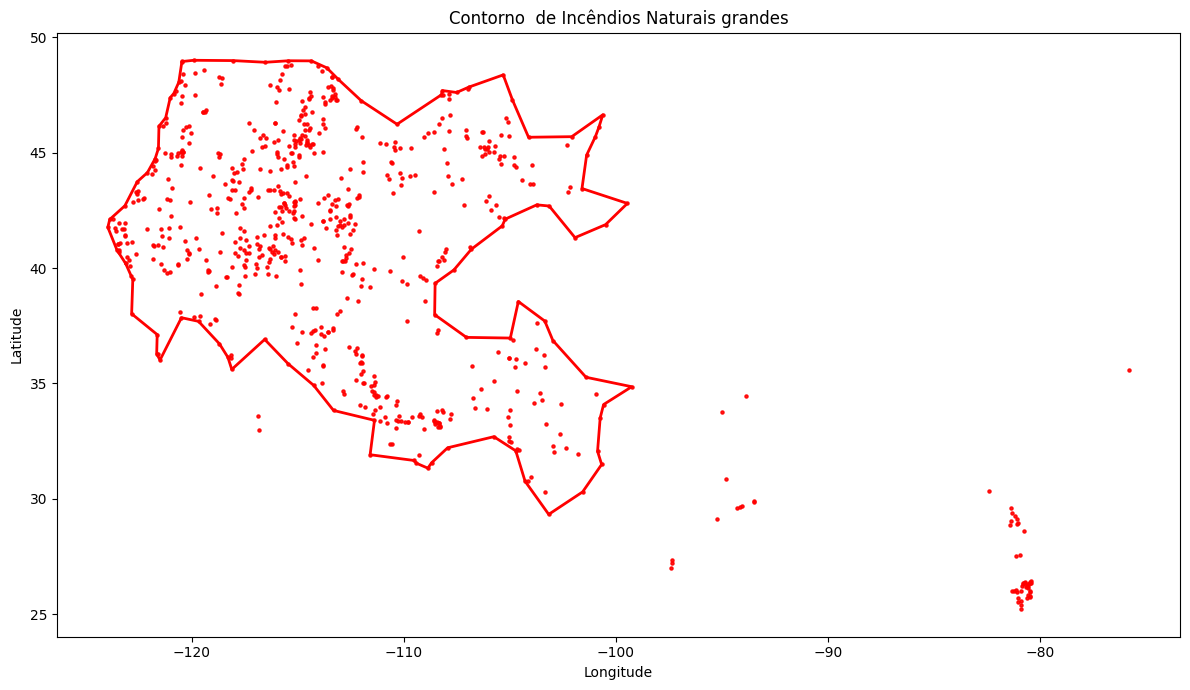

In [44]:
from shapely.geometry import Polygon
import alphashape

# Filtrar apenas pontos com longitude >= -130
coords_filtrados = naturais_grandes[naturais_grandes['LONGITUDE'] >= -130][['LONGITUDE', 'LATITUDE']].values

# Gerar o polígono de contorno (concave hull) - apenas um polígono
alpha = 1.5  # ajuste conforme necessário
contorno = alphashape.alphashape(coords_filtrados, alpha)

# Se for multipolígono, pega apenas o maior polígono
if contorno.geom_type == 'MultiPolygon':
    contorno = max(contorno.geoms, key=lambda p: p.area)

# Plotar o polígono junto com os pontos filtrados
plt.figure(figsize=(12, 7))
plt.scatter(coords_filtrados[:,0], coords_filtrados[:,1], s=5, alpha=0.9, color='red')
# Para deixar o contorno mais amplo, diminua o valor de alpha (por exemplo, alpha = 0.8)
alpha = 0.8
contorno = alphashape.alphashape(coords_filtrados, alpha)
if contorno.geom_type == 'MultiPolygon':
    contorno = max(contorno.geoms, key=lambda p: p.area)
x, y = contorno.exterior.xy
plt.plot(x, y, color='red', linewidth=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Contorno  de Incêndios Naturais grandes')
plt.tight_layout()
plt.show()


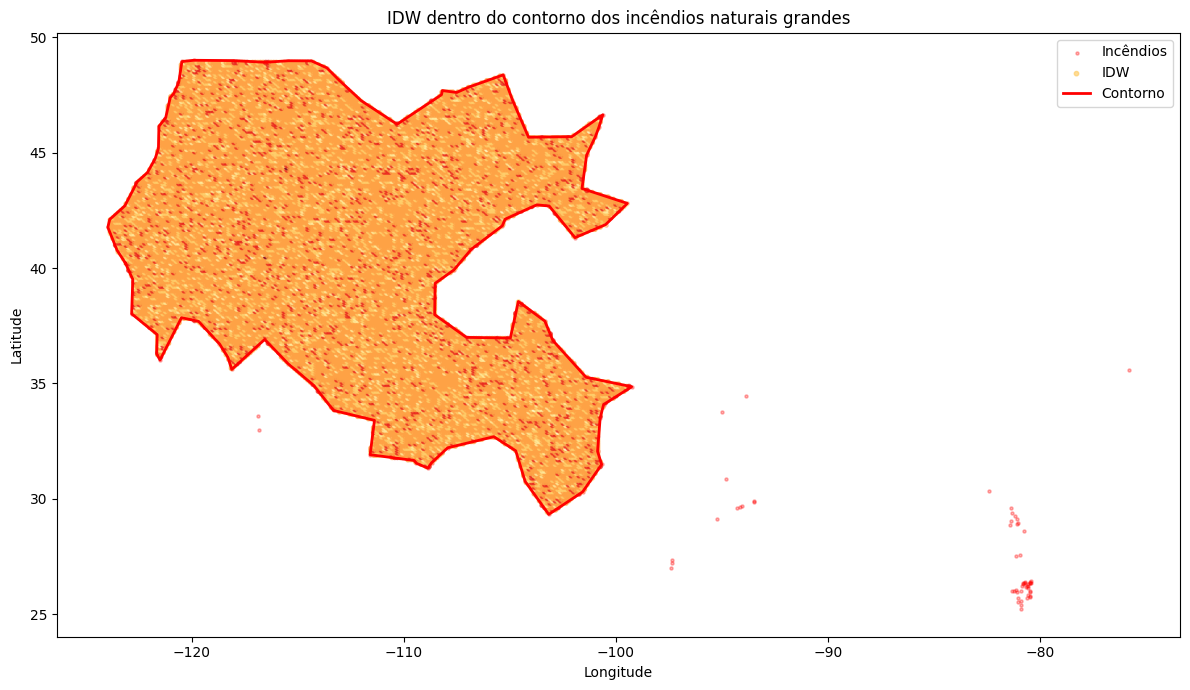

In [46]:
from scipy.spatial import cKDTree

# Pontos conhecidos (incêndios naturais grandes)
coords = coords_filtrados
values = np.ones(len(coords))  # ou use outra métrica se desejar

# Gerar grid de pontos dentro do polígono de contorno
minx, miny, maxx, maxy = contorno.bounds
grid_x, grid_y = np.meshgrid(
	np.linspace(minx, maxx, 200),
	np.linspace(miny, maxy, 200)
)
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Filtrar apenas os pontos dentro do polígono
from shapely.geometry import Point
mask = np.array([contorno.contains(Point(xy)) for xy in grid_points])
grid_points_inside = grid_points[mask]

# Pontos onde interpolar (dentro do contorno)
points_interp = grid_points_inside

# Parâmetro de potência do IDW
power = 2

# Construir árvore para busca eficiente
tree = cKDTree(coords)
distances, idx = tree.query(points_interp, k=8)  # k vizinhos mais próximos

# Evitar divisão por zero
distances[distances == 0] = 1e-10

# Calcular pesos IDW
weights = 1 / distances**power
weights /= weights.sum(axis=1)[:, None]

# Interpolação IDW
z_idw = np.sum(weights * values[idx], axis=1)

# Plotar resultado
plt.figure(figsize=(12, 7))
plt.scatter(coords[:,0], coords[:,1], s=5, alpha=0.3, color='red', label='Incêndios')
plt.scatter(points_interp[:,0], points_interp[:,1], c=z_idw, cmap='YlOrRd', s=10, alpha=0.7, label='IDW')
x, y = contorno.exterior.xy
plt.plot(x, y, color='red', linewidth=2, label='Contorno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IDW dentro do contorno dos incêndios naturais grandes')
plt.legend()
plt.tight_layout()
plt.show()
